In [1]:
import math
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

In [2]:
# Cargar el dataset
file_path = '../data/train.csv'
data = pd.read_csv(file_path, index_col=0)
# Mostrar las primeras filas del dataset
print (data.dtypes.value_counts())
display (data.head(5))

int64      13
float64     6
object      6
Name: count, dtype: int64


,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
id,,,,,,,,,,,,,,,,,,,,,
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


# EDA

In [3]:
# Información básica del dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 700000 entries, 0 to 699999
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 700000 non-null  int64  
 1   alcohol_consumption_per_week        700000 non-null  int64  
 2   physical_activity_minutes_per_week  700000 non-null  int64  
 3   diet_score                          700000 non-null  float64
 4   sleep_hours_per_day                 700000 non-null  float64
 5   screen_time_hours_per_day           700000 non-null  float64
 6   bmi                                 700000 non-null  float64
 7   waist_to_hip_ratio                  700000 non-null  float64
 8   systolic_bp                         700000 non-null  int64  
 9   diastolic_bp                        700000 non-null  int64  
 10  heart_rate                          700000 non-null  int64  
 11  cholesterol_total              

In [4]:
data.isnull().sum() # Verificar valores nulos en cada columna

age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
diagnosed_diabetes                    0


In [5]:
data.duplicated().sum() # Verificar filas duplicadas

np.int64(0)

In [6]:
data.shape # (número de filas, número de columnas)
target = "diagnosed_diabetes" # Nombre de la columna objetivo

In [7]:
# Identificar columnas que parecen ser booleanas ocultas
def is_hidden_boolean(series):
    values = set(series.dropna().unique())
    return values.issubset({0, 1})

hidden_bools = [
    col for col in data.columns 
    if data[col].dtype in ["float64", "int64"]
    and is_hidden_boolean(data[col])
]
data[hidden_bools] = data[hidden_bools].astype("bool")
print("Columnas que parecen ser booleanas ocultas:", hidden_bools)

Columnas que parecen ser booleanas ocultas: ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']


In [8]:
obj_cols = data.select_dtypes(include='object').columns # Seleccionar columnas de tipo objeto
# data[obj_cols] = data[obj_cols].astype("string") # Convertir columnas de tipo objeto a string
categorial_cols = list(hidden_bools) + list(obj_cols) # Columnas categóricas
print("Columnas categóricas:", categorial_cols)

Columnas categóricas: ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


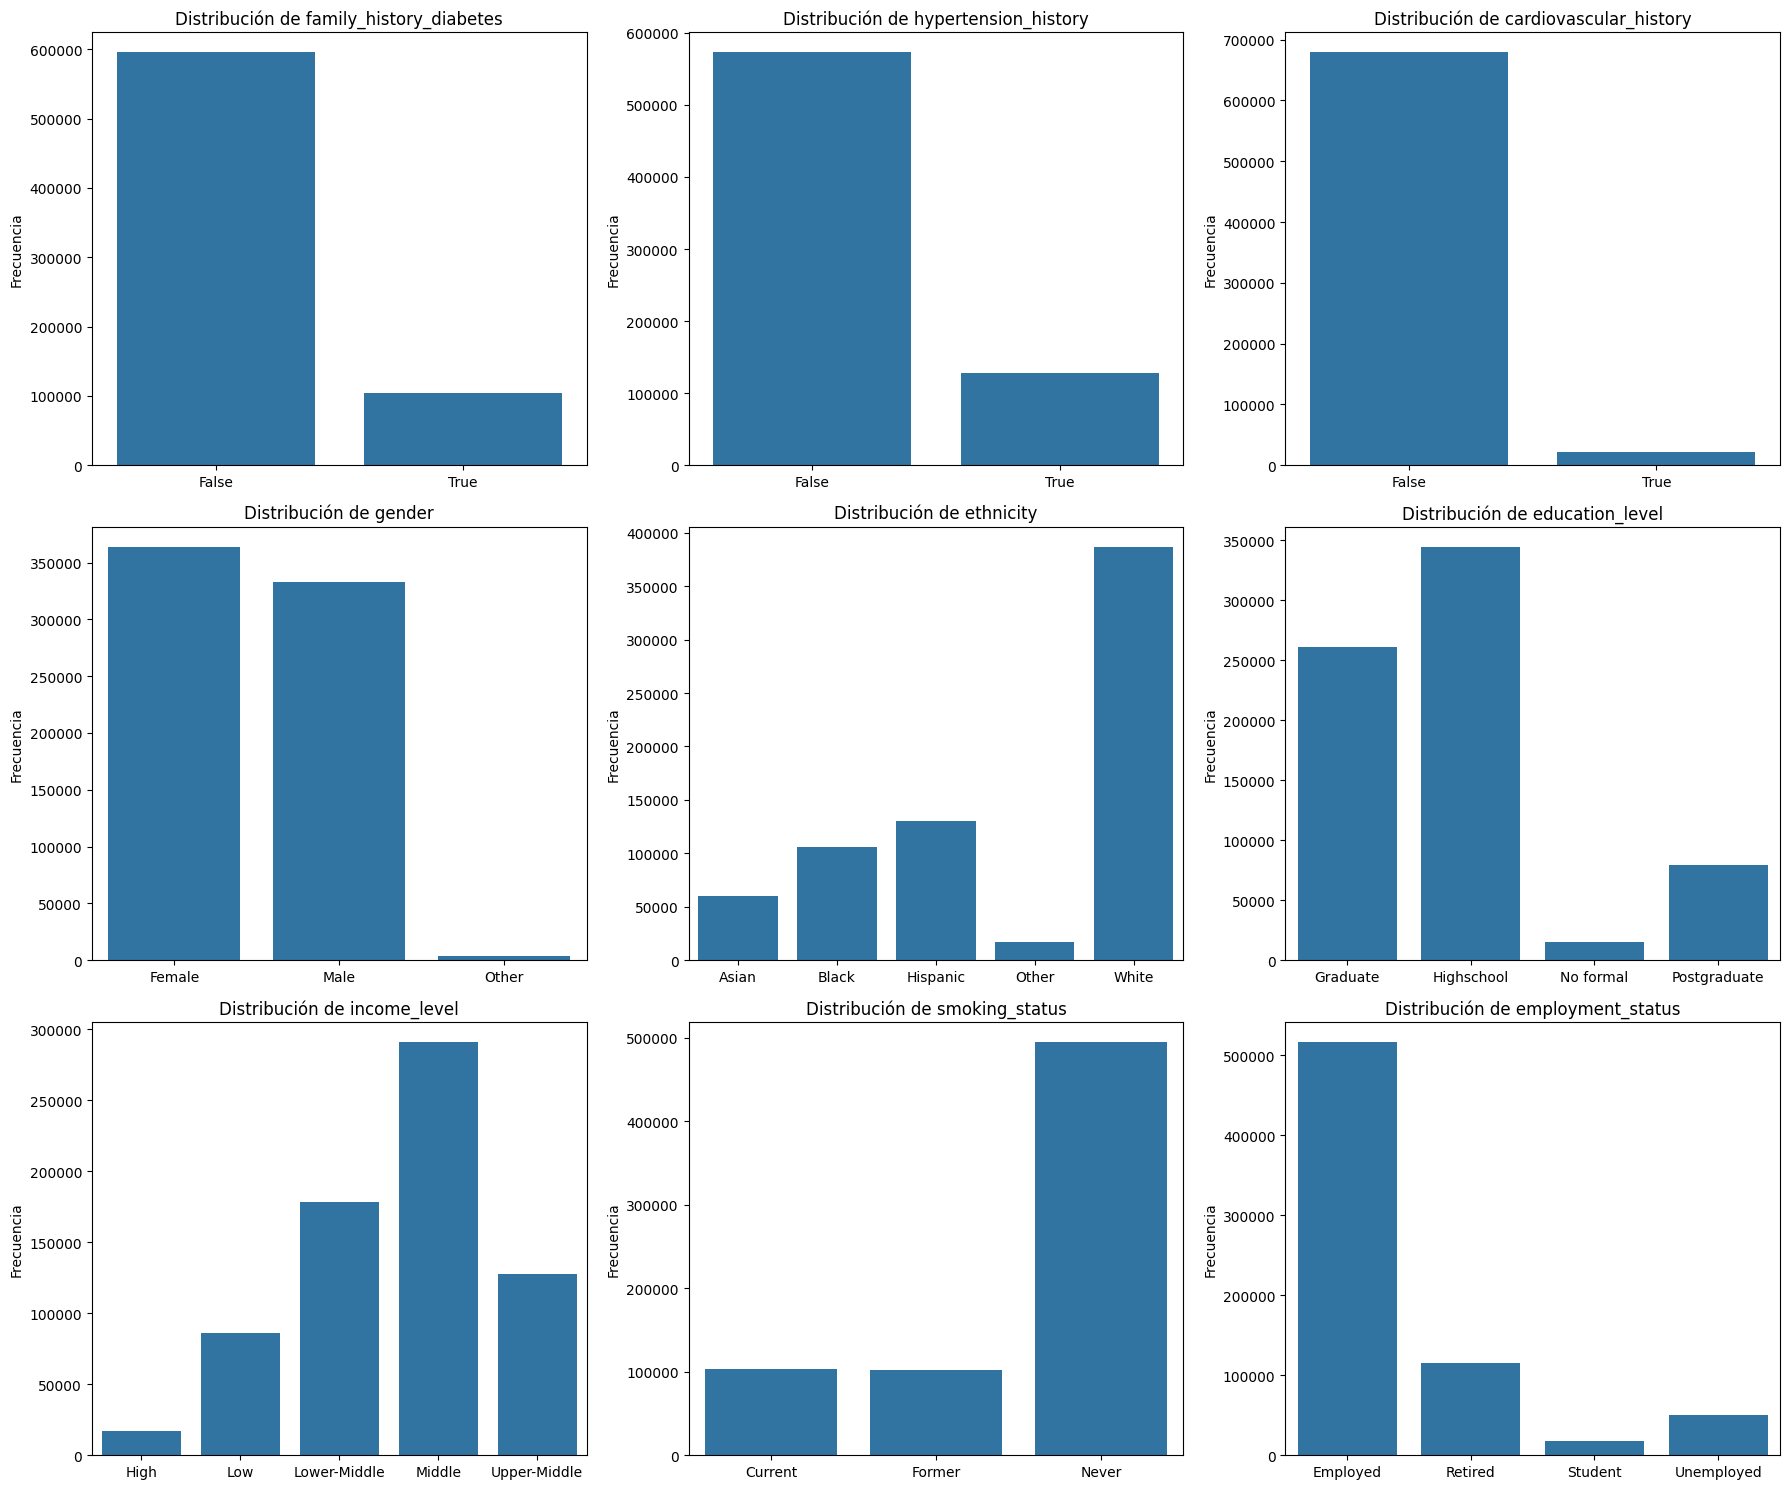

In [9]:
# Visualizar la distribución de las columnas categóricas
cols_to_plot = [c for c in categorial_cols if c != target]
n_cols = 3
n_rows = math.ceil(len(cols_to_plot) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, cols_to_plot): # Graficar distribución de cada columna categórica
   
    sns.countplot(
                x=data[col],
        order=sorted(data[col].dropna().unique()), 
        ax=ax
    )
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")


for i in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [10]:
data.describe().T # Estadísticas descriptivas de las características numéricas

,count,mean,std,min,25%,50%,75%,max
age,700000.0,50.359734,11.655520,19.00,42.00,50.00,58.00,89.00
alcohol_consumption_per_week,700000.0,2.072411,1.048189,1.00,1.00,2.00,3.00,9.00
physical_activity_minutes_per_week,700000.0,80.230803,51.195071,1.00,49.00,71.00,96.00,747.00
diet_score,700000.0,5.963695,1.463336,0.10,5.00,6.00,7.00,9.90
sleep_hours_per_day,700000.0,7.002200,0.901907,3.10,6.40,7.00,7.60,9.90
screen_time_hours_per_day,700000.0,6.012733,2.022707,0.60,4.60,6.00,7.40,16.50
bmi,700000.0,25.874684,2.860705,15.10,23.90,25.90,27.80,38.40
waist_to_hip_ratio,700000.0,0.858766,0.037980,0.68,0.83,0.86,0.88,1.05
systolic_bp,700000.0,116.294193,11.010390,91.00,108.00,116.00,124.00,163.00
diastolic_bp,700000.0,75.440924,6.825775,51.00,71.00,75.00,80.00,104.00


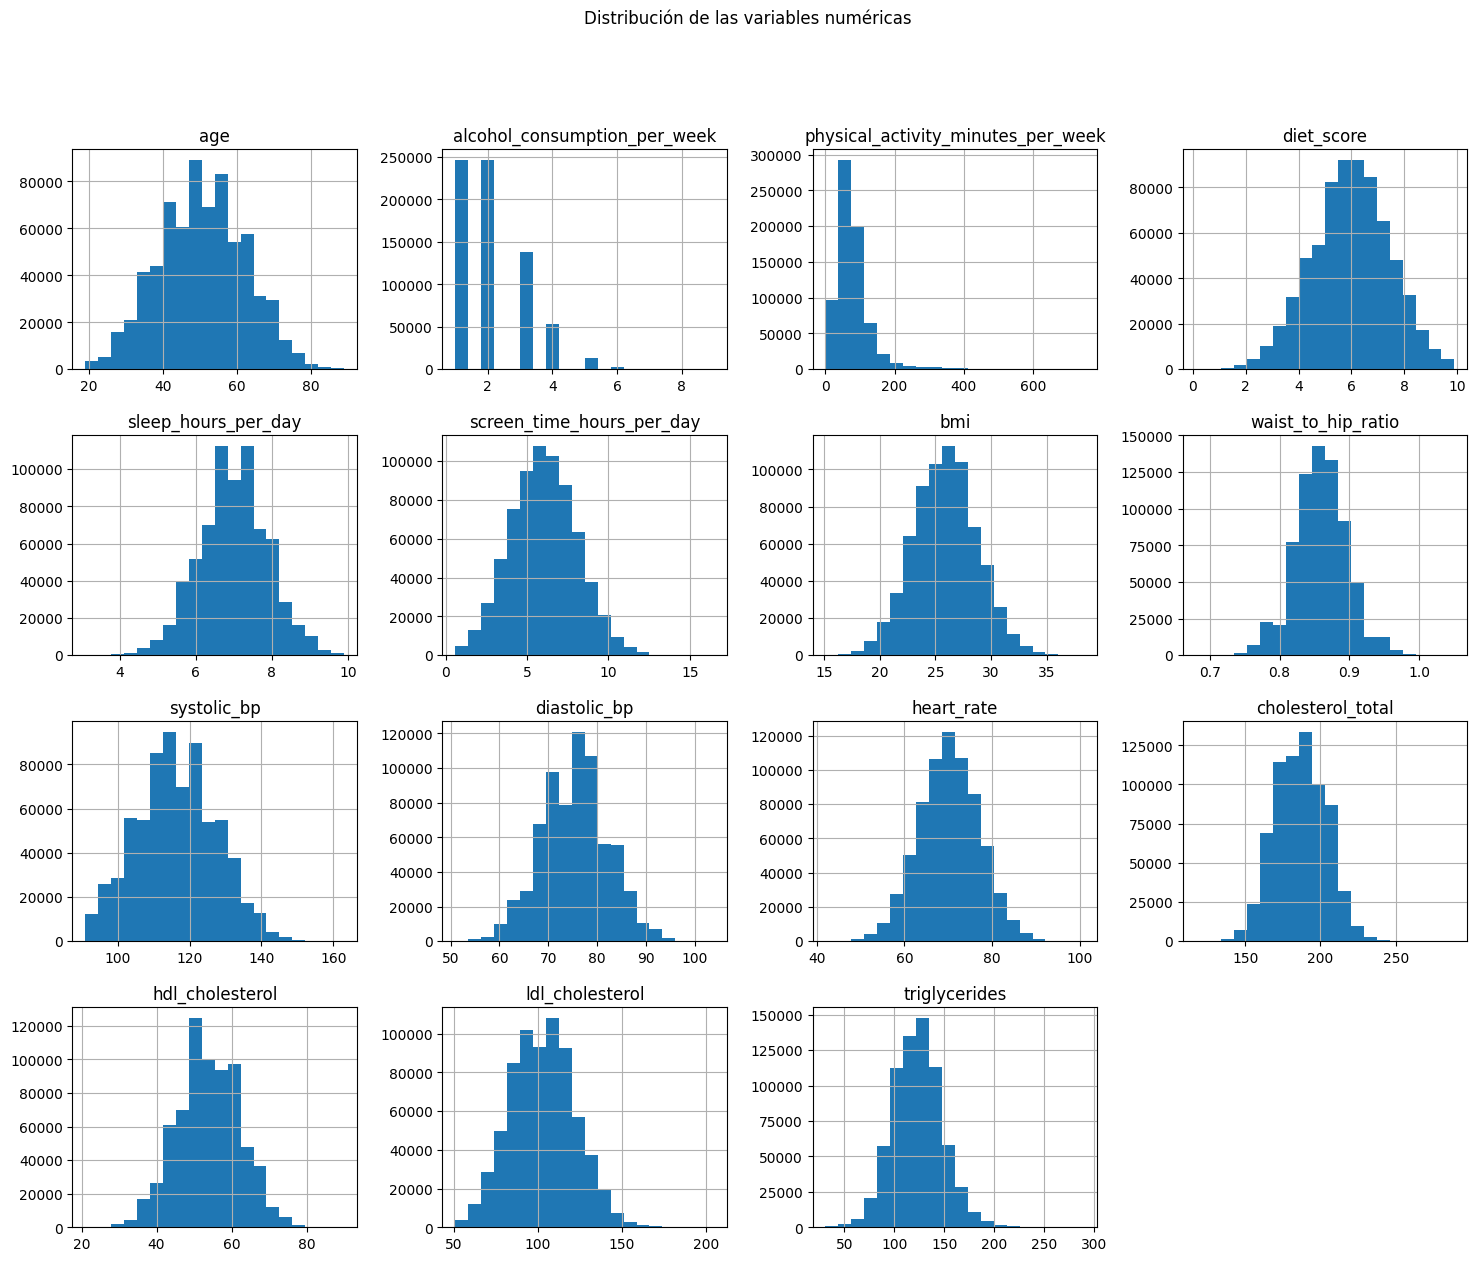

In [11]:
data.hist(bins=20, figsize=(18,14)) # Histogramas de todas las variables numéricas
plt.suptitle('Distribución de las variables numéricas')
plt.show()

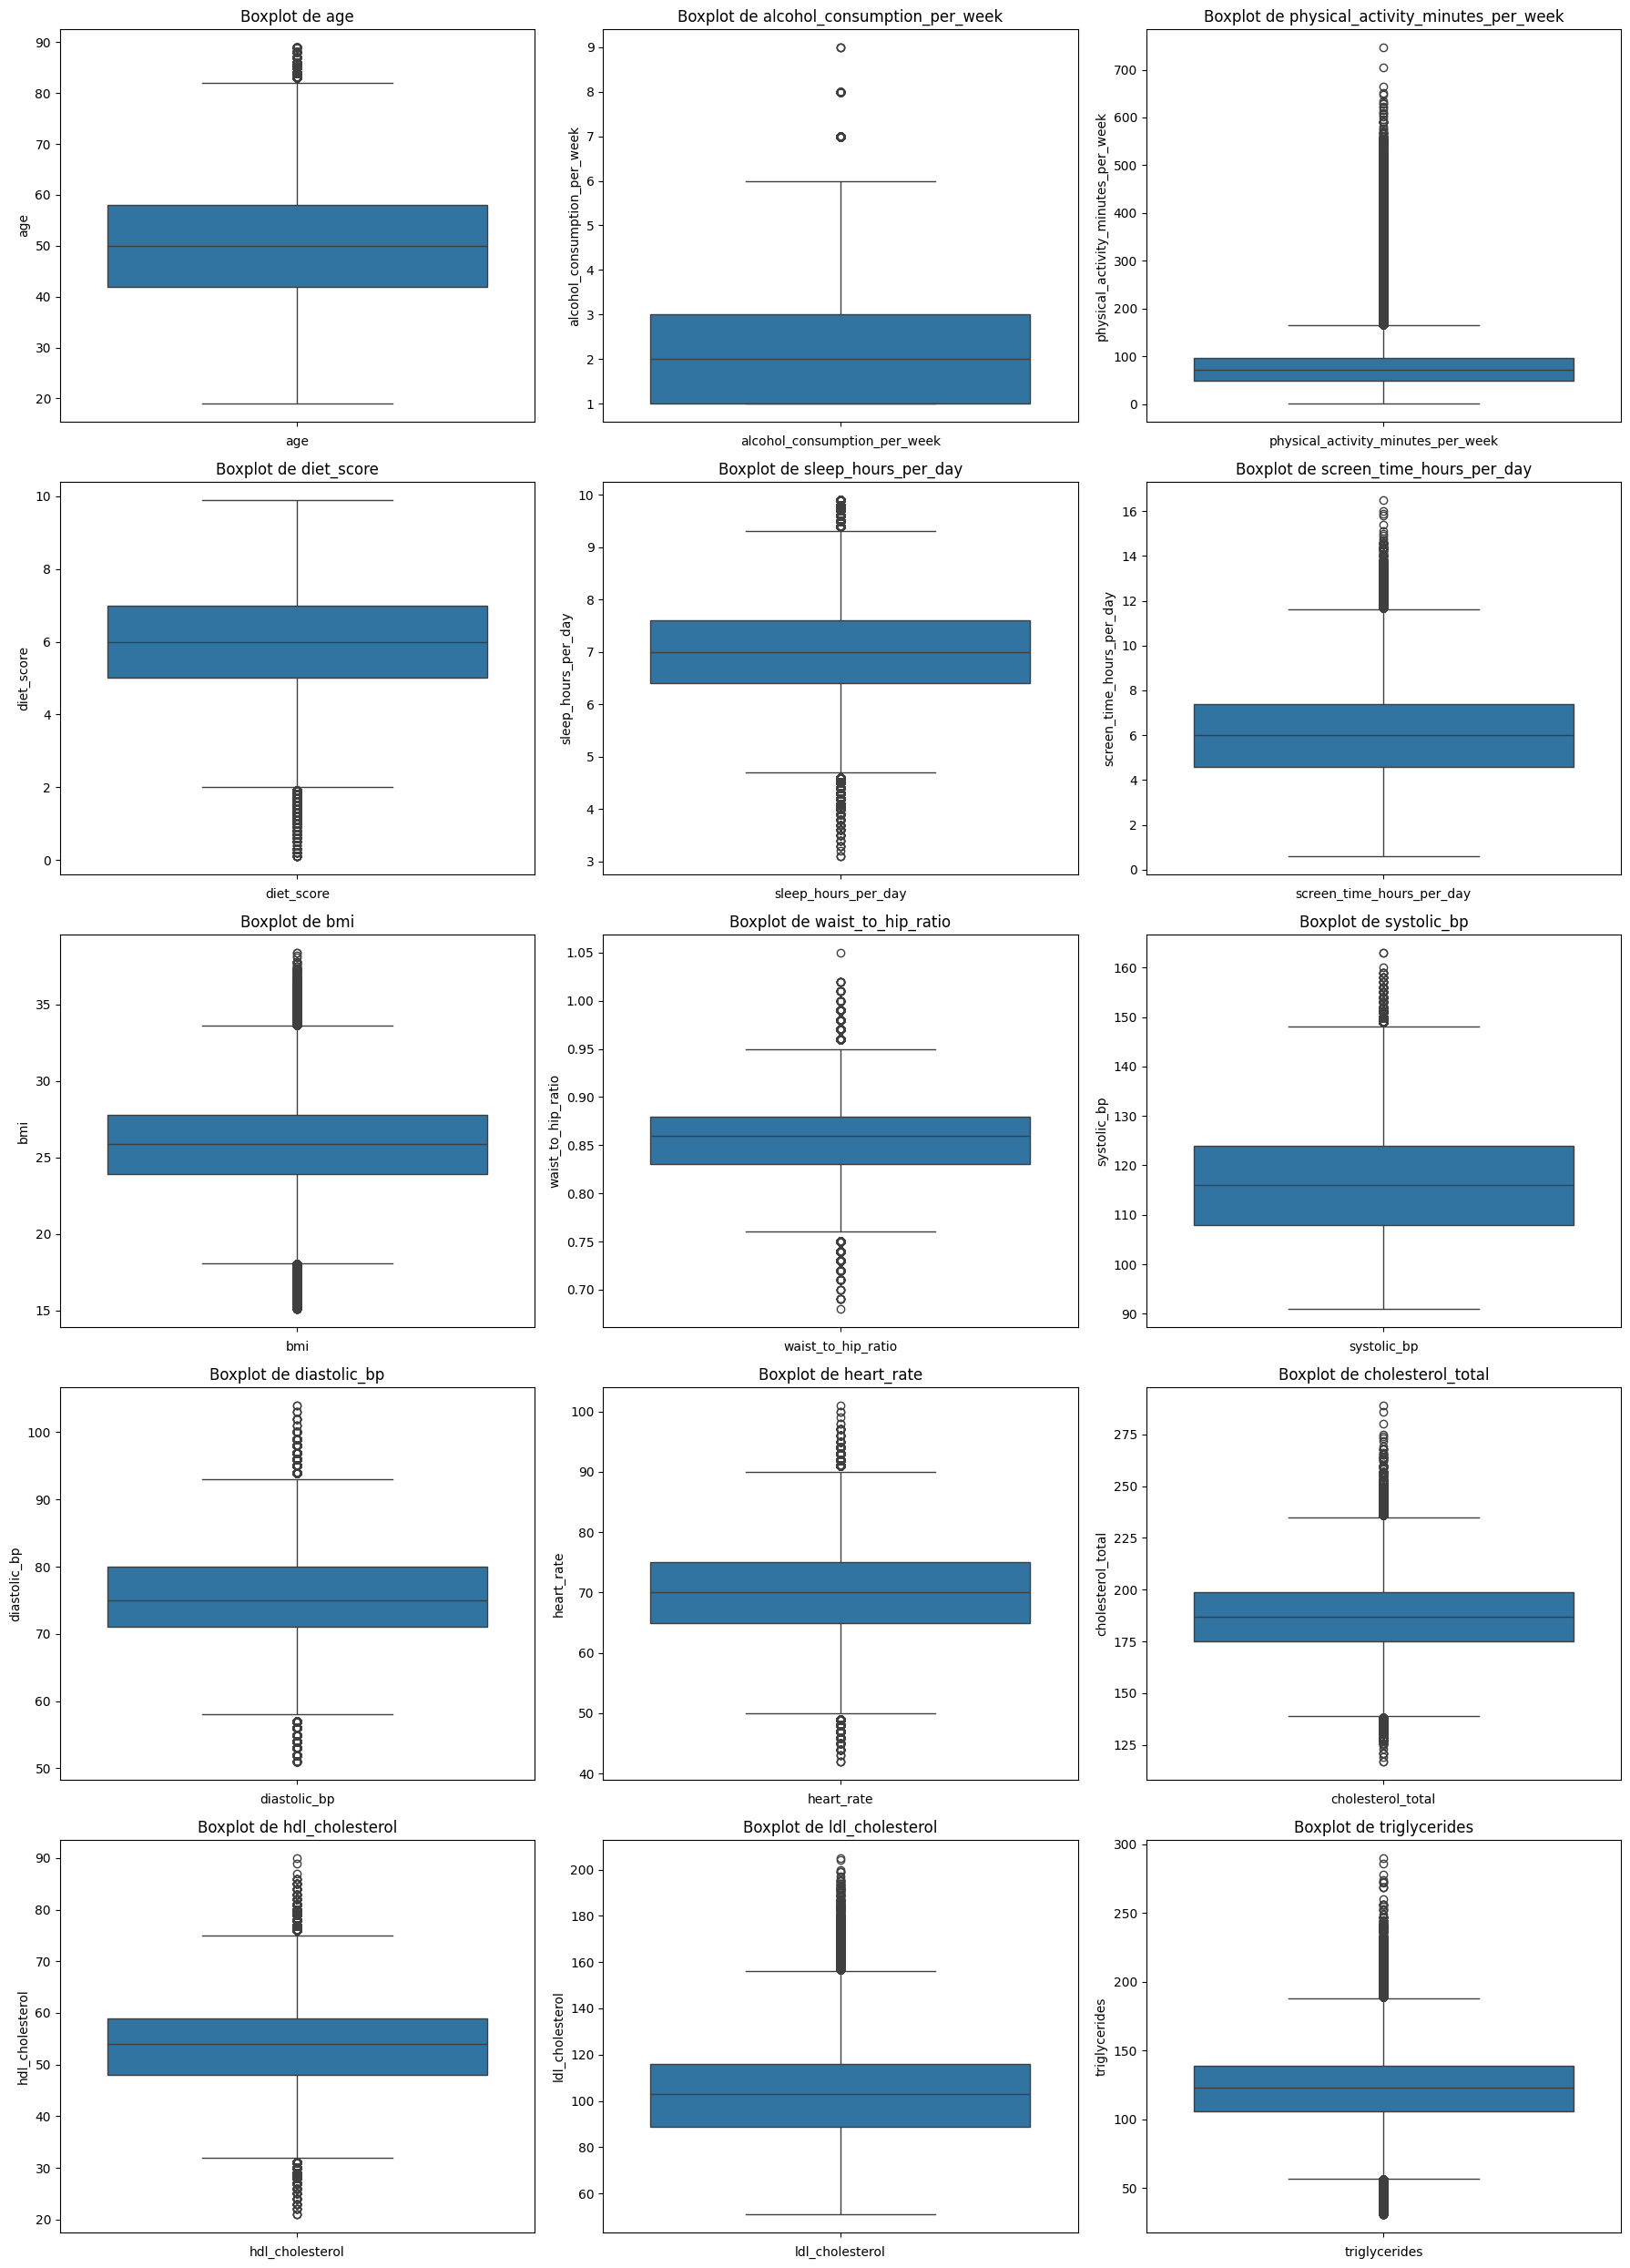

In [12]:
num_cols = data.select_dtypes(include=np.number).columns
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols): # Graficar boxplots de cada columna numérica
    sns.boxplot(y=data[col], ax=ax)
    ax.set_title(f'Boxplot de {col}')
    ax.set_xlabel(col)

for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Análisis de la variable Objetivo

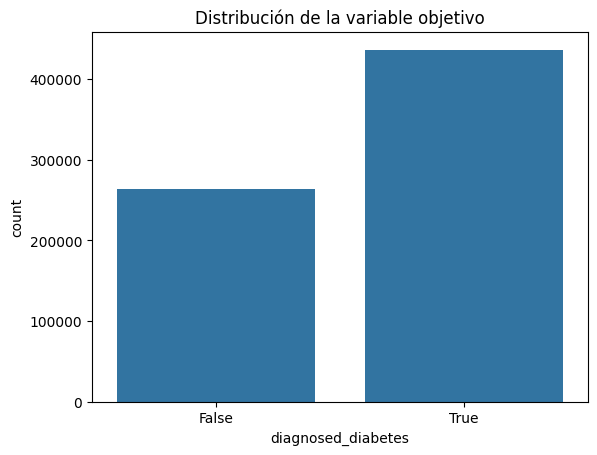

In [13]:
sns. countplot(x=target, data=data)
plt.title('Distribución de la variable objetivo')
plt.show()

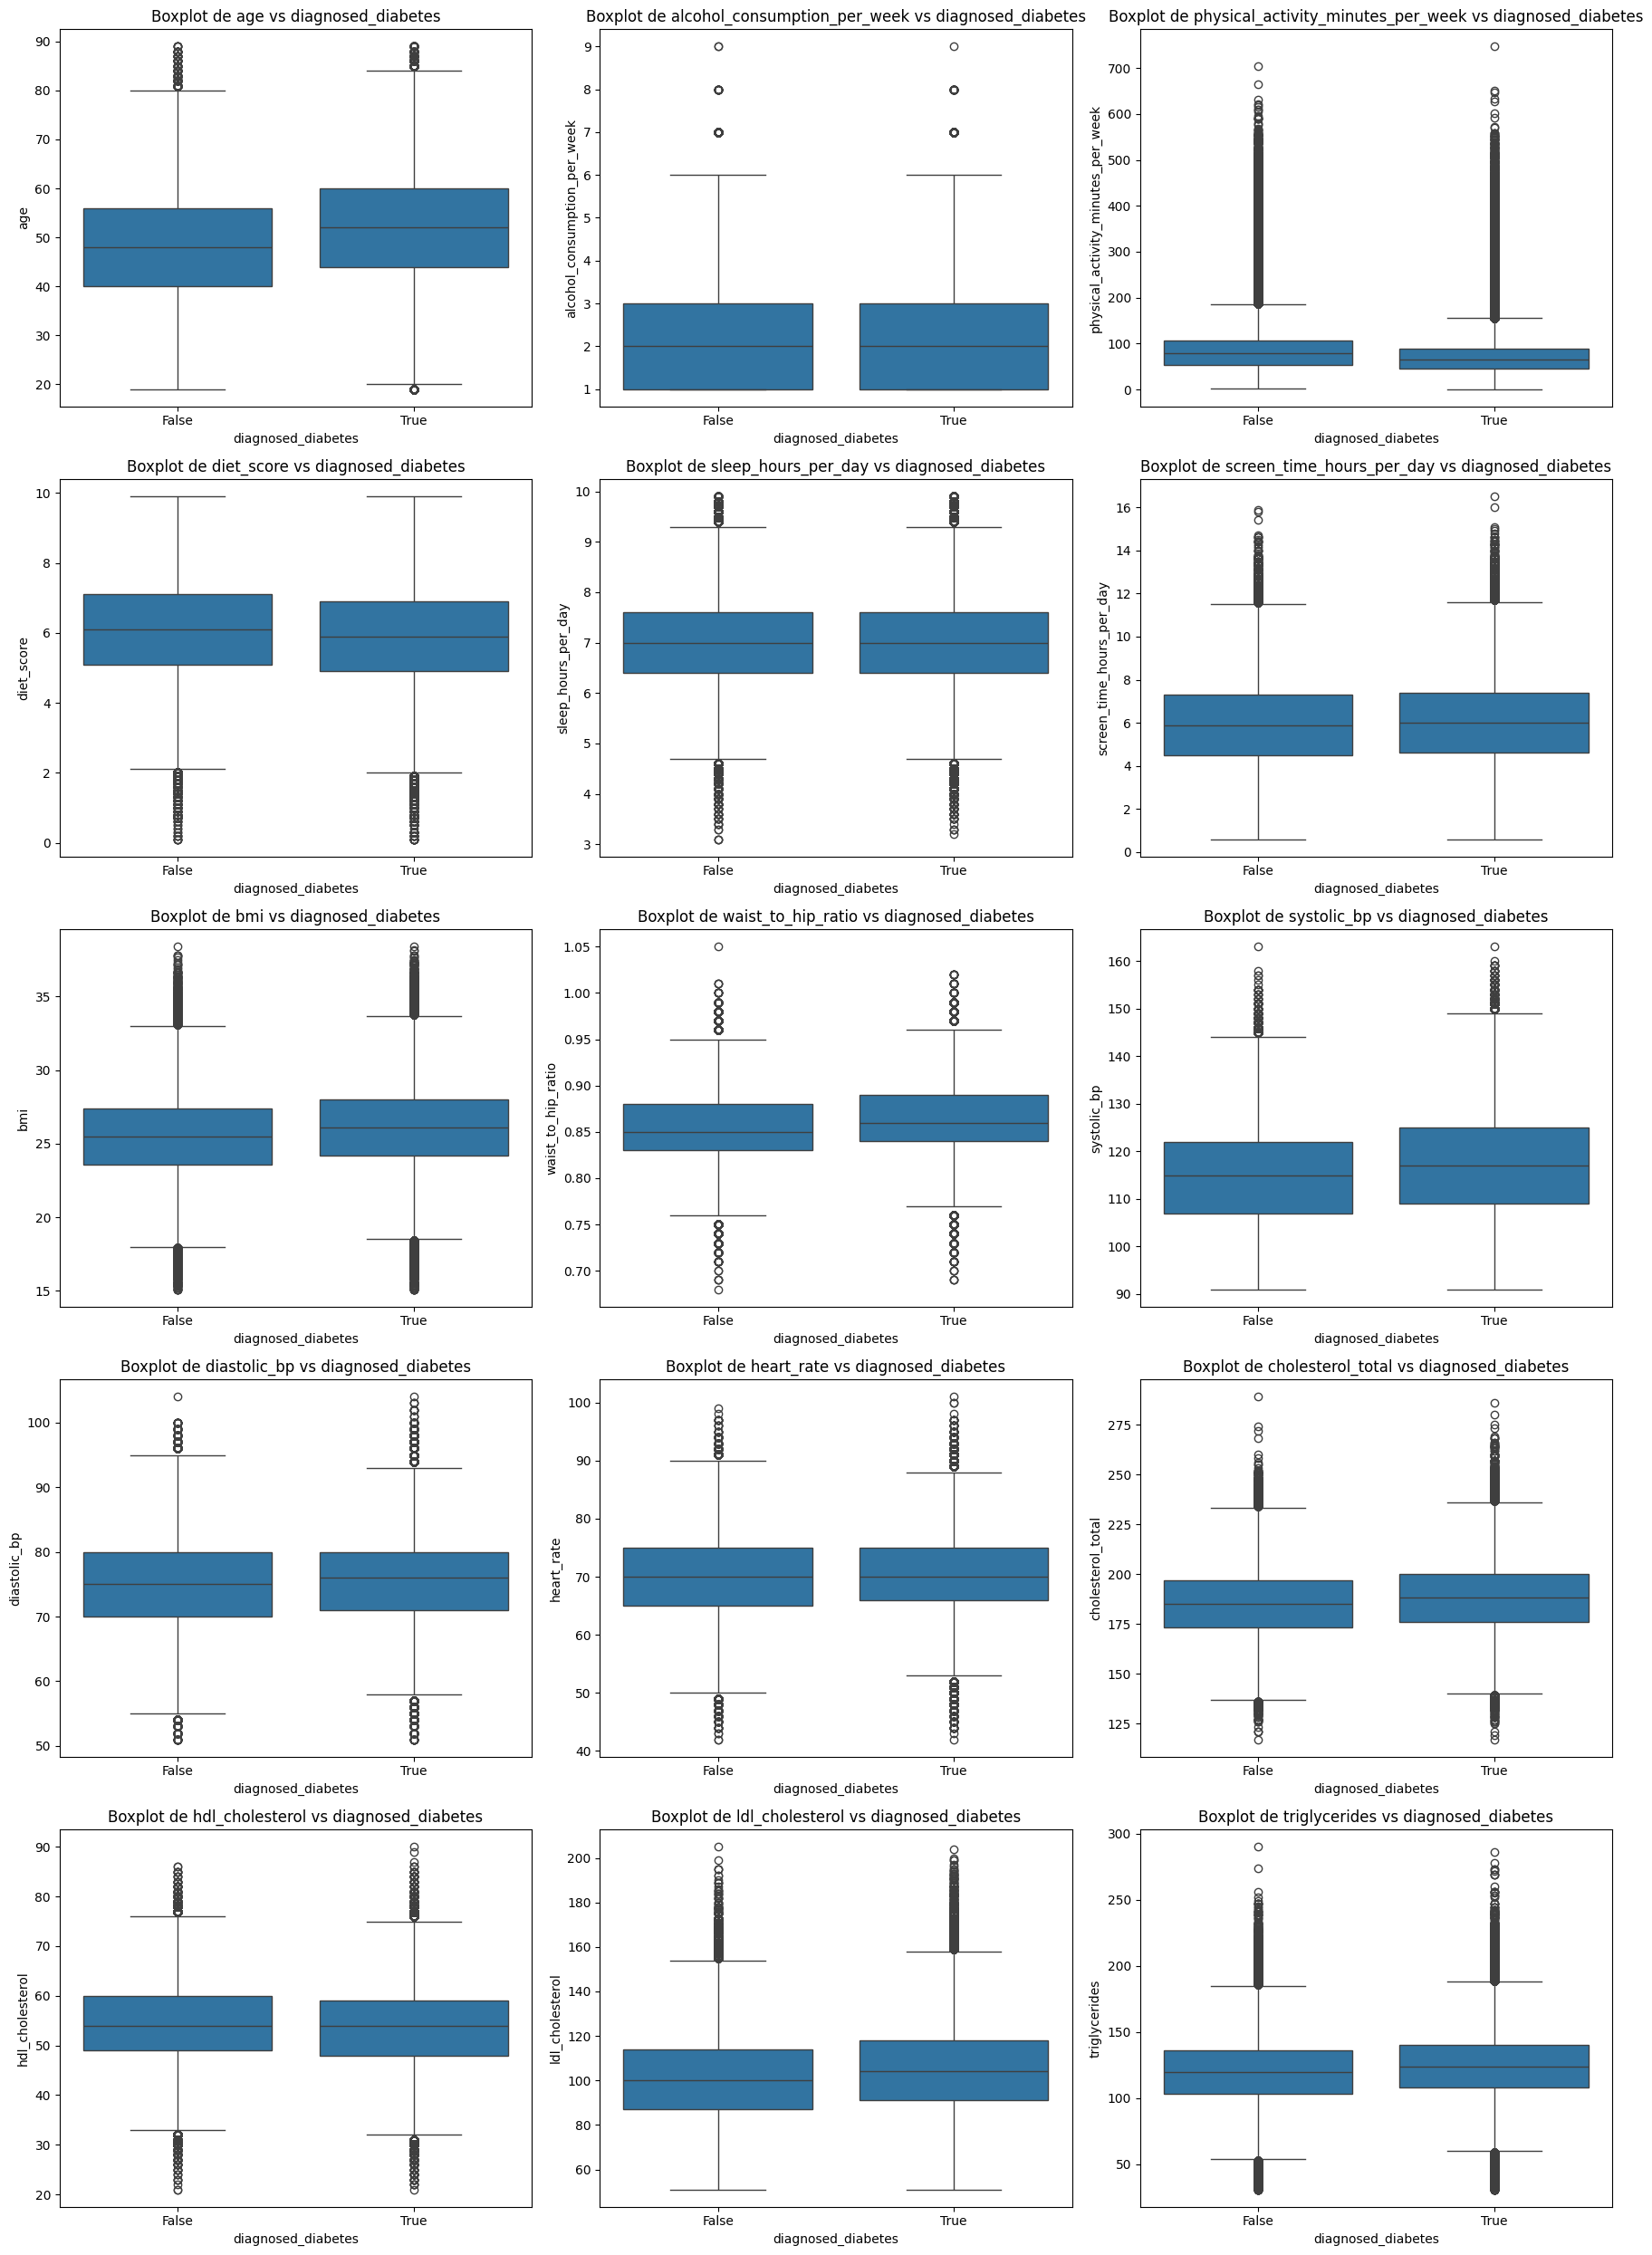

In [14]:
# Graficar boxplots de variables numéricas segmentadas por la variable objetivo

n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols): 
    sns.boxplot(
        x=data[target], 
        y=data[col], 
        ax=ax
    )
    ax.set_title(f'Boxplot de {col} vs {target}')
    ax.set_xlabel(target)
    ax.set_ylabel(col)
       
       
for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

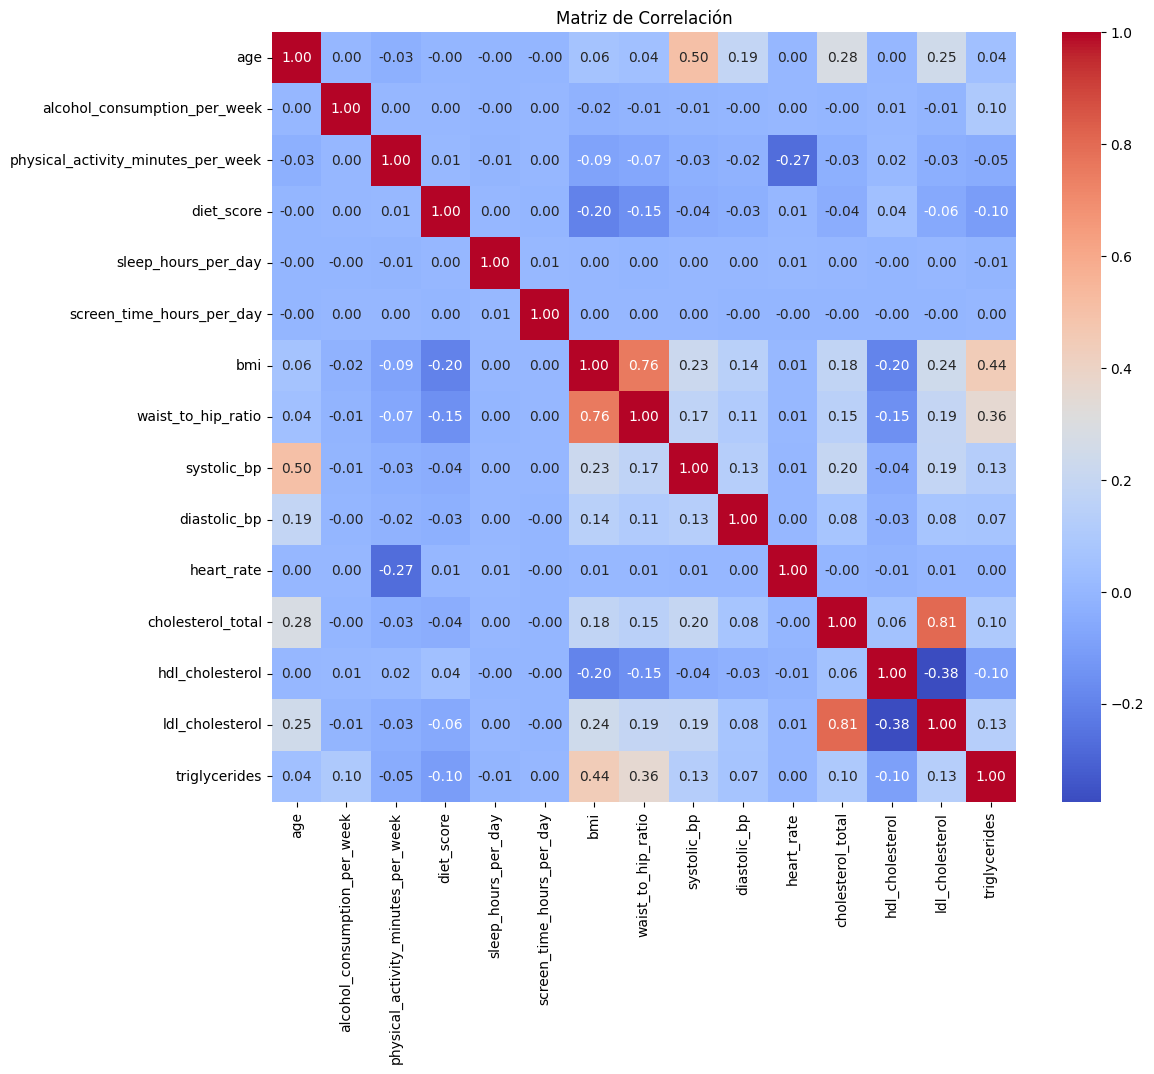

In [15]:
corr = data[num_cols].corr() # Matriz de correlación

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


In [16]:
print(obj_cols)

Index(['gender', 'ethnicity', 'education_level', 'income_level',
       'smoking_status', 'employment_status'],
      dtype='object')


In [17]:
# Codificación de variables categóricas
data[hidden_bools] = data[hidden_bools].astype("int") # Convertir columnas booleanas ocultas a tipo int
ordinal_cols = {
    "education_level" : {'No formal': 0,  'Highschool': 1, 'Graduate': 2, 'Postgraduate': 3},
    "income_level" : {'Low': 0,'Lower-Middle': 1, 'Middle': 2, 'Upper-Middle': 3, 'High': 4}
}

for col, mapping in ordinal_cols.items():
    data[col] = data[col].map(mapping)

nominal_cols = [c for c in obj_cols if c not in ordinal_cols] # Diccionario para mapear categorías a números 
data = pd.get_dummies(
    data,
    columns=nominal_cols, 
    drop_first=True) 

bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype("int") # Convertir columnas booleanas a tipo int
data.dtypes.value_counts()

int64      27
float64     5
Name: count, dtype: int64

In [18]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
X = data.drop(columns=[target]) # Características
y = data[target] # Variable objetivo

X_sample, _, y_sample, _ = train_test_split(
    X,  
    y,  
    train_size=0.3,
    stratify=y,  
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X_sample,  
    y_sample,  
    test_size=0.2,
    stratify=y_sample,  
    random_state=42
)

del data, X, y, X_sample, y_sample  # Liberar memoria

In [19]:
pipeline = Pipeline (steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(
        class_weight='balanced',
        n_jobs=1,
        random_state=42
    ))])

In [20]:
# Entrenamiento del modelo
param_grid = {
    'model__n_estimators': [400, 600],
    'model__max_depth': [ 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [2, 4, 6],
    'model__max_features': ['sqrt', 'log2'],
    'model__class_weight': ['balanced', None]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=3,
    scoring="recall",
    cv=4,
    n_jobs=1,
    random_state=50,
    verbose=2
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] END model__class_weight=None, model__max_depth=10, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=600; total time= 1.3min
[CV] END model__class_weight=None, model__max_depth=10, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=600; total time= 1.3min
[CV] END model__class_weight=None, model__max_depth=10, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=600; total time= 1.3min
[CV] END model__class_weight=None, model__max_depth=10, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=600; total time= 1.3min
[CV] END model__class_weight=balanced, model__max_depth=20, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=600; total time= 2.3min
[CV] END model__class_weight=ba

In [21]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [22]:
print(best_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        min_samples_leaf=4, min_samples_split=5,
                                        n_estimators=600, n_jobs=1,
                                        random_state=42))])


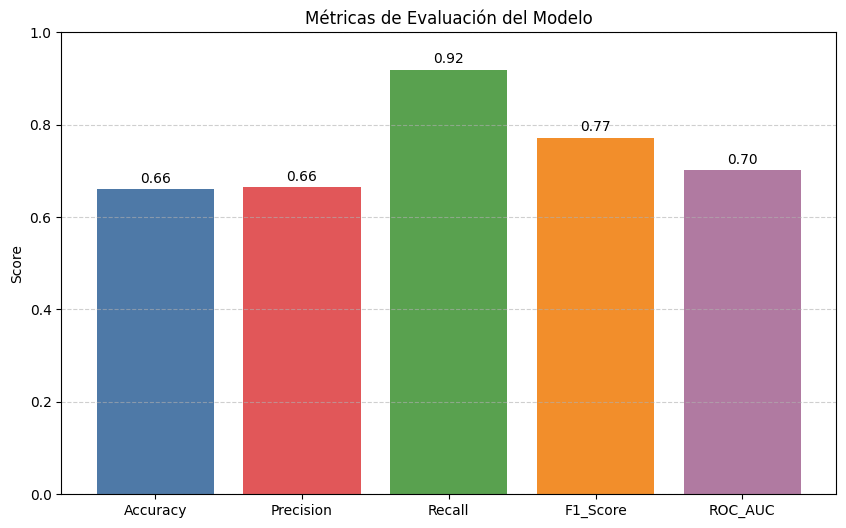

Accuracy  : 0.6603571428571429
Precision : 0.6646579129232896
Recall    : 0.918481167392467
F1_Score  : 0.7712219139415907
ROC_AUC   : 0.7017563479506748


In [23]:
# Evaluación y métricas
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred)
Recall = recall_score(y_test, y_pred)
F1_Score = f1_score(y_test, y_pred)
ROC_AUC = roc_auc_score(y_test, y_proba)

joblib.dump(best_model, '../random_forest_diabetes_model_oscar{F1_Score}.pkl')

metrics = {
    "Accuracy": Accuracy, "Precision": Precision, "Recall": Recall, "F1_Score": F1_Score, "ROC_AUC": ROC_AUC
}

colors = ["#4E79A7", "#E15759",  "#59A14F", "#F28E2B", "#B07AA1"] 

plt.figure(figsize=(10,6))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height * 1.01, 
        f'{height:.2f}', 
        ha='center', 
        va='bottom',
        fontsize=10
    )

plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Métricas de Evaluación del Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("Accuracy  :", Accuracy)
print("Precision :", Precision)
print("Recall    :", Recall)
print("F1_Score  :", F1_Score)
print("ROC_AUC   :", ROC_AUC)



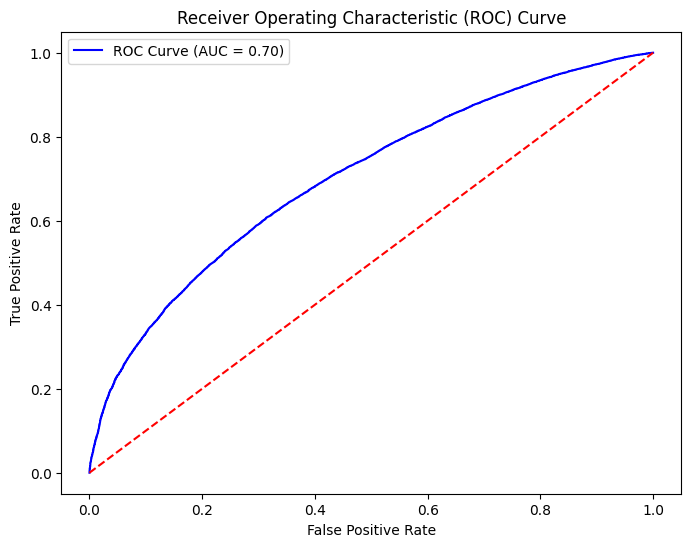

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

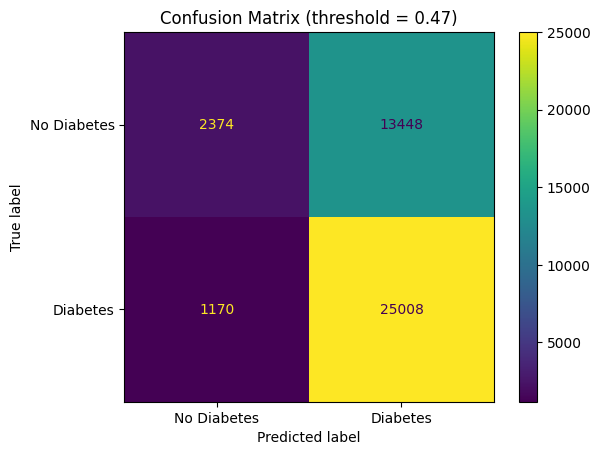

In [25]:
thresholds = np.arange(0.2, 0.6, 0.01)
scores = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    scores.append(f1_score(y_test, y_pred_t))
best_threshold = thresholds[np.argmax(scores)]

y_pred_thr = (y_proba >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_thr)

disp = ConfusionMatrixDisplay(cm, display_labels=["No Diabetes","Diabetes"])
disp.plot(values_format='d')
plt.title(f'Confusion Matrix (threshold = {best_threshold:.2f})')
plt.show()